Federico Manenti: 790032


Matteo Licciardello: 799368

# Processing di segnali mono-dimensionali

In questo file sono presenti 3 approcci differenti:
* Rete CNN
* Rete GRU
* GMM

La rete CNN è il vero e proprio modello che verrà presentato durante la demo live, gli altri due sono approcci pensati ed implementati precedentemente che raggiungono comunque ottimi risultati.

## Import

In [1]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

TensorFlow 2.x selected.
     |████████████████████████████████| 378kB 3.0MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale
from tqdm import tqdm

import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.mixture import GaussianMixture

from keras import layers, optimizers, callbacks, Model, losses, models, applications
from keras.preprocessing import image as kimage

import cv2 as cv
from joblib import dump,load
import _pickle as cPickle

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Definisco la directory nel mio Drive da cui saranno prelevati i dati
dir_drive = "/content/drive/My Drive/progetto_dsim/data/tutto/"

#Definisco le categorie associate alle cartelle-immagini
category = ["fede", "liccia"]

## Preprocessing MFCC

In [0]:
def add_noise(audio_signal, noise_factor = 30):
        noise = np.random.randn(len(audio_signal))
        data_noise = np.add(audio_signal, noise_factor*noise) # se si vuole più rumore cambiare il fattore moltiplicativo
        return data_noise 

def mfccs(input, rate, n_mfcc = 13):
    mfcc = librosa.feature.mfcc(input*1.0, sr = rate, n_mfcc = n_mfcc)
    return mfcc

def identity(input, rate, n_mfcc):
  return input

### Caricamento dati augmentati per train e non per test

In [0]:
def create_data(n_mfcc = 13, feature_extractor=identity):

  for cat in category: 
    path = os.path.join(dir_drive,cat)  # creare il path a fede, liccia
    class_num = category.index(cat)  # ottenere la label (0, 1).

    for f in tqdm(os.listdir(path)): 
      try:
       if f.endswith('.wav'):
         # Carica file ed estraine le features
          signal, rate = librosa.core.load(os.path.join(path,f), mono=True, sr = 44100)
          #signal_noise = add_noise(signal, 0.005)

          cur_features = feature_extractor(signal, rate, n_mfcc)
          #cur_features_noise = feature_extractor(signal_noise, rate, n_mfcc)

          features.append(cur_features)
          labels.append(class_num)
          #features.append(cur_features_noise)
          #labels.append(class_num)

      except Exception as e:  # in the interest in keeping the output clean...
        pass

In [0]:
labels = []
features = []
create_data(feature_extractor=identity, n_mfcc=13)

100%|██████████| 254/254 [00:53<00:00,  4.67it/s]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

In [0]:
# Aggiunta rumore

a = []
for i in tqdm(X_train):
    a.append(add_noise(i, 0.005))
X_train = X_train + a
y_train = y_train + y_train

100%|██████████| 458/458 [00:01<00:00, 237.04it/s]


In [0]:
# Calcolo MFCC

for i in tqdm(range(len(X_train))):
    X_train[i] = mfccs(X_train[i], 44100, 13)

for i in tqdm(range(len(X_test))):
    X_test[i] = mfccs(X_test[i], 44100, 13)

100%|██████████| 51/51 [00:01<00:00, 46.49it/s]


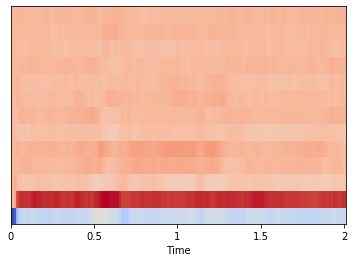

In [0]:
lid.specshow(X_train[0], sr=44100, x_axis='time')
plt.show()

In [0]:
width = X_train[0].shape[0]
height = X_train[0].shape[1]

In [0]:
X_train = np.array(list(X_train)).reshape(-1, width, height, 1)
X_test = np.array(list(X_test)).reshape(-1, width, height, 1)

In [0]:
mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0)

np.save("/content/drive/My Drive/progetto_dsim/consegna/mean_audio", mean)
np.save("/content/drive/My Drive/progetto_dsim/consegna/std_audio", std)

In [0]:
X_train = (X_train-mean) / std

In [0]:
X_test = (X_test-mean) / std

## Addestramento CNN

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(64, (2,2), activation='relu', input_shape=(width,height,1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (2,2), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.GlobalAveragePooling2D()) 
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 172, 64)       320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 172, 64)       256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 86, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 86, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 85, 64)         16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 85, 64)         256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 42, 64)        

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

j = 0

In [0]:
mc = callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/progetto_dsim/modelli/audio" + str(j) + ".hdf5" ,
                               monitor="val_loss",
                               save_best_only = True)

history = model.fit(X_train, y_train, 
                    batch_size=32,
                    epochs=100,
                    validation_split=0.2,
                    callbacks = [mc])

j += 1

Train on 732 samples, validate on 184 samples
Epoch 1/100
732/732 [==============================] - 7s 10ms/step - loss: 0.5154 - acc: 0.7609 - val_loss: 0.6469 - val_acc: 0.5380
Epoch 2/100
732/732 [==============================] - 0s 316us/step - loss: 0.3959 - acc: 0.8087 - val_loss: 0.6646 - val_acc: 0.5054
Epoch 3/100
732/732 [==============================] - 0s 317us/step - loss: 0.3494 - acc: 0.8388 - val_loss: 0.6840 - val_acc: 0.5054
Epoch 4/100
732/732 [==============================] - 0s 315us/step - loss: 0.3114 - acc: 0.8566 - val_loss: 0.6977 - val_acc: 0.5054
Epoch 5/100
732/732 [==============================] - 0s 305us/step - loss: 0.2737 - acc: 0.8825 - val_loss: 0.6950 - val_acc: 0.5054
Epoch 6/100
732/732 [==============================] - 0s 306us/step - loss: 0.2463 - acc: 0.9071 - val_loss: 0.6843 - val_acc: 0.5054
Epoch 7/100
732/732 [==============================] - 0s 307us/step - loss: 0.2473 - acc: 0.8948 - val_loss: 0.6915 - val_acc: 0.5054
Epoch 8/10

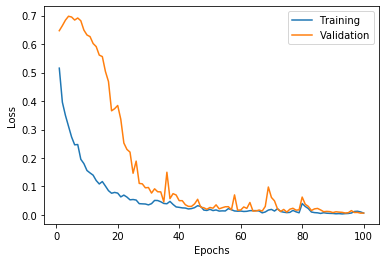

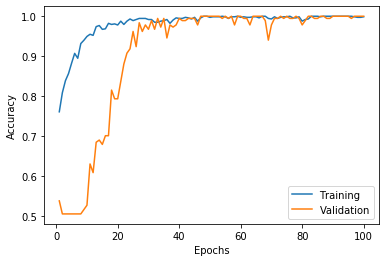

In [0]:
x_plot = list(range(1,history.epoch[-1]+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['acc'])
    plt.plot(x_plot, network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])

    
plot_history(history)

## Test CNN

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("TEST LOSS:", test_loss)
print("TEST ACCURACY:", test_acc)

51/51 [==============================] - 0s 558us/step
TEST LOSS: 0.008754377089002553
TEST ACCURACY: 1.0


In [0]:
prova = models.load_model("/content/drive/My Drive/progetto_dsim/modelli/audio0.hdf5")
prova.evaluate(X_test, y_test)

51/51 [==============================] - 0s 2ms/step


[0.010272568749154316, 1.0]

In [0]:
print(classification_report(y_test, prova.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        57

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



## GRU

In [0]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)

In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [0]:
# Da runnare solo se non si erano già normalizzati i dati precedentemente

mean = X_train.mean(axis = 0)
std = X_train.std(axis = 0)
X_train = (X_train-mean) / std
X_test = (X_test-mean) / std

In [0]:
model = models.Sequential()


model.add(layers.GRU(64, return_sequences=False, input_shape = (width, height)))
model.add(layers.Dense(2, activation="softmax"))

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

In [0]:
history = model.fit(X_train, y_train,
          batch_size = 16,
          epochs = 10,
          validation_split=0.2)

Train on 1742 samples, validate on 436 samples
Epoch 1/10
1742/1742 [==============================] - 2s 1ms/step - loss: 0.5363 - acc: 0.7210 - val_loss: 0.3990 - val_acc: 0.8211
Epoch 2/10
1742/1742 [==============================] - 2s 1ms/step - loss: 0.2734 - acc: 0.8869 - val_loss: 0.2464 - val_acc: 0.9014
Epoch 3/10
1742/1742 [==============================] - 2s 1ms/step - loss: 0.1468 - acc: 0.9478 - val_loss: 0.2094 - val_acc: 0.9174
Epoch 4/10
1742/1742 [==============================] - 2s 1ms/step - loss: 0.0715 - acc: 0.9811 - val_loss: 0.1531 - val_acc: 0.9427
Epoch 5/10
1742/1742 [==============================] - 2s 1ms/step - loss: 0.0313 - acc: 0.9954 - val_loss: 0.1631 - val_acc: 0.9404
Epoch 6/10
1742/1742 [==============================] - 2s 1ms/step - loss: 0.0146 - acc: 0.9983 - val_loss: 0.1583 - val_acc: 0.9381
Epoch 7/10
1742/1742 [==============================] - 2s 1ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.1555 - val_acc: 0.9472
Epoch 8/10
1742

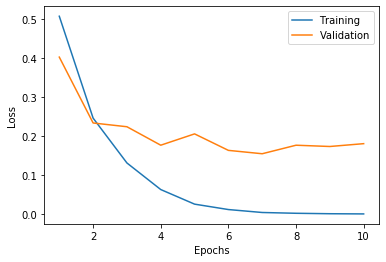

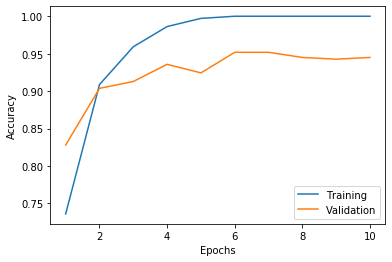

In [0]:
x_plot = list(range(1,history.epoch[-1]+2))
plot_history(history)

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("TEST LOSS:", test_loss)
print("TEST ACCURACY:", test_acc)

122/122 [==============================] - 0s 228us/step
TEST LOSS: 0.2791646311029059
TEST ACCURACY: 0.9180327653884888


## GMM

In [0]:
#Definisco la directory nel mio Drive da cui saranno prelevati i dati
dir_drive = "/content/drive/My Drive/progetto_dsim/data/tutto"

#Definisco le categorie associate alle cartelle-immagini
category = ["fede", "liccia"]

In [0]:
def identity(input, rate, n_mfcc):
  return input


def calculate_delta(array):

    rows,cols = array.shape
    deltas = np.zeros((20,cols))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0: # se sono alla prima riga non posso prendere il valore mfcc precedente
                first = 0
            else:
                first = i-j
                
            # Se sono all'ultima riga non posso prendere il valore mfcc successivo. 
            # Il comando shape restituisce il numero di righe presente nell'array partendo da 1, ma si accede all'array partendo da 0,
            # il numero totale di righe sarà quindi rows-1 se si parte da zero.
            if i+j > rows-1: 
                second = rows-1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def mfccs(input, rate, n_mfcc):
    mfcc = librosa.feature.mfcc(input*1.0, sr = rate, n_mfcc = n_mfcc)
    return mfcc


def create_data(n_mfcc = 20, feature_extractor=identity):

  for cat in category: 
    path = os.path.join(dir_drive,cat) 
    class_num = category.index(cat) 

    for f in tqdm(os.listdir(path)): 
      try:
       if f.endswith('.wav'):
         # Carica file ed estraine le features
          signal, rate = librosa.core.load(os.path.join(path,f), mono=True, sr = 44100)

          mfcc_feat = feature_extractor(signal, rate, n_mfcc)
          #delta = calculate_delta(mfcc_feat)
          #combined = np.vstack((mfcc_feat,delta)) 

          features.append(mfcc_feat)
          labels.append(class_num)

              
      except Exception as e:  # in the interest in keeping the output clean...
        pass

In [0]:
labels = []
features = []
create_data(feature_extractor=mfccs, n_mfcc=20)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [0]:
#Scambio degli assi per problemi di memoria

X_train = np.swapaxes(X_train, 2, 1)
X_test = np.swapaxes(X_test, 2, 1)

In [0]:
# Viene costruito il vettore di features per ogni speaker concatenando le feature dei diversi audio

features_fede = np.asarray(())
features_matteo = np.asarray(())

for index, vector in enumerate(X_train):
    if y_train[index] == 0:
        # caso fede
        if features_fede.size == 0:
            features_fede = vector
        else:
            features_fede = np.vstack((features_fede, vector))
            
            
    else: # caso matteo

        if features_matteo.size == 0:
            features_matteo = vector
        else:
            features_matteo = np.vstack((features_matteo, vector))

In [61]:
dest = "/content/drive/My Drive/progetto_dsim/modelli/GMM/" # path dove salvare modelli di training 
features = ['features_fede', 'features_matteo']

for feature_name in features:
    
    feature = eval(features[features.index(feature_name)])
    
    #tuning del numero di componenti per GMM tramite BIC
    n_components = np.arange(1, 21)
    models = [GaussianMixture(n, random_state=66, max_iter=200).fit(feature) for n in n_components]
    bic = [m.bic(feature) for m in models]
    
        
    # scegliamo il modello con il numero di componenti che minimizza il BIC
    gmm = models[bic.index(min(bic))]
    
    
    picklefile = feature_name.split("_")[1]+".gmm"
    cPickle.dump(gmm, open(dest + picklefile,'wb'))
    print('+ modeling completed for speaker:', picklefile, " with data point = ", feature.shape, 
          ". Selected ", gmm.get_params(True)['n_components'], "components for the GMM model.")

+ modeling completed for speaker: fede.gmm  with data point =  (93593, 20) . Selected  20 components for the GMM model.
+ modeling completed for speaker: matteo.gmm  with data point =  (94804, 20) . Selected  20 components for the GMM model.


In [62]:
modelpath = "/content/drive/My Drive/progetto_dsim/modelli/GMM/"
 
gmm_files = [os.path.join(modelpath,fname) for fname in
              os.listdir(modelpath) if fname.endswith('.gmm')]
 
# Load the Models
models    = [cPickle.load(open(fname,'rb')) for fname in gmm_files]
speakers   = [0,1]


y_pred = []
for index, test_feature in enumerate(X_test):
    
    log_likelihood = np.zeros(len(models)) 
     
    for i in range(len(models)):
        gmm = models[i]  
        scores = np.array(gmm.score_samples(test_feature)) #cambiato in score_samples
        log_likelihood[i] = scores.sum()
        
    winner = np.argmax(log_likelihood)
    y_pred.append(speakers[winner])
    print(y_test[index], "detected as - ", speakers[winner])
    

0 detected as -  0
1 detected as -  1
1 detected as -  1
0 detected as -  0
1 detected as -  1
0 detected as -  0
1 detected as -  1
0 detected as -  0
0 detected as -  0
1 detected as -  1
0 detected as -  0
0 detected as -  0
0 detected as -  0
1 detected as -  1
1 detected as -  1
0 detected as -  0
0 detected as -  0
0 detected as -  0
1 detected as -  1
1 detected as -  1
0 detected as -  0
1 detected as -  1
0 detected as -  0
1 detected as -  1
1 detected as -  1
0 detected as -  0
1 detected as -  1
1 detected as -  1
0 detected as -  1
1 detected as -  1
1 detected as -  1
0 detected as -  0
1 detected as -  1
1 detected as -  1
0 detected as -  0
1 detected as -  1
1 detected as -  1
0 detected as -  0
0 detected as -  0
0 detected as -  0
0 detected as -  0
1 detected as -  1
1 detected as -  1
0 detected as -  0
1 detected as -  1
0 detected as -  0
0 detected as -  0
0 detected as -  0
1 detected as -  1
0 detected as -  0
0 detected as -  0
1 detected as -  1
0 detected a

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[64  1]
 [ 2 55]]


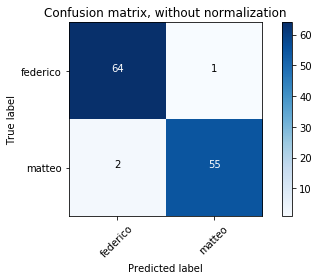

In [63]:
cnf_mtrx = confusion_matrix(y_test, y_pred)


import itertools
plt.figure()
plot_confusion_matrix(cnf_mtrx, classes=['federico', 'matteo'], 
                      title='Confusion matrix, without normalization')